<h1 align="center"><b>Gun Detection Using CNN</b></h1>

---

**Introduction**

There have been many terrorist attacks and lone-wolf attacks around the world. These attacks have caused immense loss of life and resources. If we can detect weapons in civilian and commercial areas through intelligent surveillance, many of these attacks can be prevented.

**Dataset collection**

This dataset is a collection of images from 9 different types of weapons. Previously, there have been datasets that has only one class Weapon or Gun. This dataset consists of 9 classes as of now: Automatic Rifle, Bazooka, Handgun, Knife, Grenade Launcher, Shotgun, SMG, Sniper, Sword. This dataset was created with the help of simple_image_download library in Python, which downloads images from internet. 100 images from each class were collected. After inspection invalid images were discarded, leaving us with a total of 714 images for all 9 classes.

**Dataset Link**
```
https://www.kaggle.com/datasets/snehilsanyal/weapon-detection-test
```



In [51]:
things_to_learn={1:'Import tensorflow and check version.',
                 2:'Install Dataset',
                 3:'Install Libraries',
                 4:'Structuring Files',
                 5:"Generating Dataframes",
                 6:'Data Visualization',
                 7:'Data Preprocessing',
                 8:'Creating CNN Model',
                 9:'Checking Model Accuracy',
                 }
things_to_learn

{1: 'Import tensorflow and check version.',
 2: 'Install Dataset',
 3: 'Install Libraries',
 4: 'Structuring Files',
 5: 'Generating Dataframes',
 6: 'Data Visualization',
 7: 'Data Preprocessing',
 8: 'Creating CNN Model',
 9: 'Checking Model Accuracy'}

# 1. Import tensorflow and check version.

In [1]:
import tensorflow
print(tensorflow.__version__)

2.11.0


# 2. Install Dataset

In [ ]:
! pip install gdown
! gdown https://drive.google.com/uc?id=1F07jM7IpoLEWeKDJwYM9NKI8YkkLNu3t
! unzip gun.zip  

# 3. Install Libraries

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
from keras.regularizers import l2
import gc
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

# 4. Structuring Files.

In [4]:
image_directory = '/content/weapon_detection/train/images/'
os.mkdir('/content/weapon_detection/train/images/gun/')
os.mkdir('/content/weapon_detection/train/images/nogun/')
for filename in os.listdir(image_directory):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        class_name = filename.split('_')[0]
        src_path ='/content/weapon_detection/train/images/'+filename
        folder=''
        if class_name=='Automatic Rifle' or class_name=='Grenade Launcher' or class_name=='Bazooka' or class_name=='Handgun' or class_name=='Shotgun' or class_name=='SMG' or class_name=='Sniper':
          folder='gun/' 
        else:
          folder='nogun/'
        dest_path='/content/weapon_detection/train/images/'+folder+filename
        shutil.move(src_path, dest_path)

In [5]:
image_directory = '/content/weapon_detection/val/images/'
os.mkdir('/content/weapon_detection/val/images/gun/')
os.mkdir('/content/weapon_detection/val/images/nogun/')
for filename in os.listdir(image_directory):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        class_name = filename.split('_')[0]
        src_path ='/content/weapon_detection/val/images/'+filename
        folder=''
        if class_name=='Automatic Rifle' or class_name=='Grenade Launcher' or class_name=='Bazooka' or class_name=='Handgun' or class_name=='Shotgun' or class_name=='SMG' or class_name=='Sniper':
          folder='gun/' 
        else:
          folder='nogun/'
        dest_path='/content/weapon_detection/val/images/'+folder+filename
        shutil.move(src_path, dest_path)

# 5. Generating Dataframes

In [6]:
gun_dir_train = Path(r'/content/weapon_detection/train/images/gun')
nogun_dir_train = Path(r'/content/weapon_detection/train/images/nogun')
gun_dir_val = Path(r'/content/weapon_detection/val/images/gun')
nogun_dir_val = Path(r'/content/weapon_detection/train/images/nogun')

In [14]:
def generate_df(img_dir, label):
    file_Path = pd.Series(list(img_dir.glob('*.*')), name='File_Path').astype(str)
    labels = pd.Series(label, name='Label', index=file_Path.index)
    df = pd.concat([file_Path, labels], axis=1)
    return df

In [8]:
gun_df_train = generate_df(gun_dir_train, 'gun')
nogun_df_train = generate_df(nogun_dir_train, 'nogun')
gun_df_val = generate_df(gun_dir_val, 'gun')
nogun_df_val = generate_df(nogun_dir_val, 'nogun')

In [9]:
all_df_train = pd.concat([gun_df_train , nogun_df_train ], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df_train.head()

,File_Path,Label
0,/content/weapon_detection/train/images/gun/Sni...,gun
1,/content/weapon_detection/train/images/gun/Han...,gun
2,/content/weapon_detection/train/images/nogun/S...,nogun
3,/content/weapon_detection/train/images/gun/Aut...,gun
4,/content/weapon_detection/train/images/gun/Sni...,gun


In [10]:
all_df_val = pd.concat([gun_df_val , nogun_df_val ], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df_val.head()

,File_Path,Label
0,/content/weapon_detection/train/images/nogun/K...,nogun
1,/content/weapon_detection/train/images/nogun/K...,nogun
2,/content/weapon_detection/val/images/gun/Handg...,gun
3,/content/weapon_detection/val/images/gun/Autom...,gun
4,/content/weapon_detection/train/images/nogun/K...,nogun


In [11]:
len(all_df_train)

571

# 6. Data Visualization

Text(0.5, 1.0, 'Gun and No Gun')

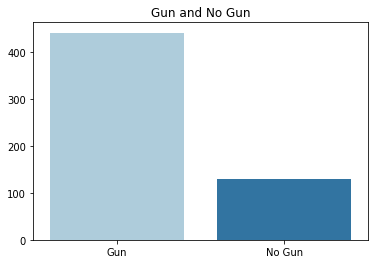

In [15]:
sns.barplot(x=['Gun','No Gun'], y=[len(gun_df_train), len(nogun_df_train)], palette='Paired' )
plt.title('Gun and No Gun')

Text(0.5, 1.0, 'Training Data vs Validation Data')

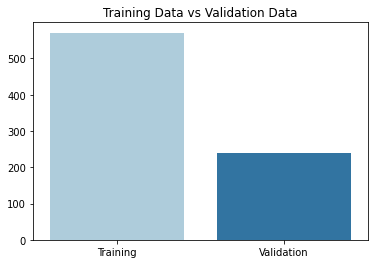

In [16]:
sns.barplot(x=['Training','Validation'], y=[len(all_df_train), len(all_df_val)], palette='Paired' )
plt.title('Training Data vs Validation Data')

# 7. Data Preprocessing 

In [20]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0) 
train_image_generator = train_gen.flow_from_dataframe(
    all_df_train,
    directory=None,
    x_col='File_Path',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=32,
    seed=42
)
val_gen = ImageDataGenerator(rescale = 1.0/255.0) 
val_image_generator = val_gen.flow_from_dataframe(
    all_df_val,
    directory=None,
    x_col='File_Path',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='binary',
    batch_size=32,
    seed=42
)

Found 571 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.


# 8. Creating CNN Model

In [21]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation="relu",kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [23]:
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = model.fit(train_image_generator,
            epochs=20,
            batch_size=32,
            validation_data=val_image_generator,
            callbacks=[model_checkpoint])
gc.collect()

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.6357
Epoch 1: val_accuracy improved from -inf to 0.46250, saving model to checkpoint/
18/18 [==============================] - 41s 2s/step - loss: 1.2202 - accuracy: 0.6357 - val_loss: 3.1387 - val_accuracy: 0.4625
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 1.0034 - accuracy: 0.7846
Epoch 2: val_accuracy improved from 0.46250 to 0.46667, saving model to checkpoint/
18/18 [==============================] - 25s 1s/step - loss: 1.0034 - accuracy: 0.7846 - val_loss: 1.7977 - val_accuracy: 0.4667
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.8686 - accuracy: 0.8564
Epoch 3: val_accuracy did not improve from 0.46667
18/18 [==============================] - 25s 1s/step - loss: 0.8686 - accuracy: 0.8564 - val_loss: 2.1350 - val_accuracy: 0.4625
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.7856 - accuracy: 0.8757
Epoch 4: val_accuracy

174

# 9. Checking Model Accuracy 

In [24]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

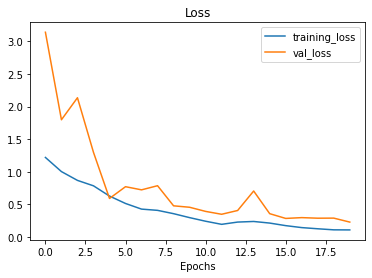

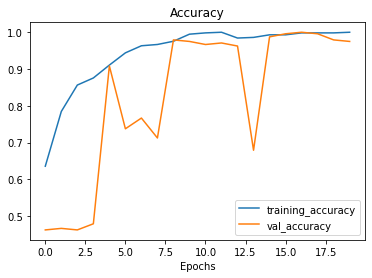

In [25]:
plot_loss_curves(r)

In [26]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [41]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[round(pred[0][0])] # if more than one output, take the max
  
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  

1/1 [==============================] - 0s 20ms/step


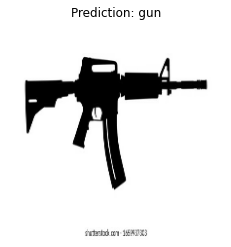

In [42]:
pred_and_plot(model, '/content/weapon_detection/val/images/gun/Automatic Rifle_13.jpeg',['gun','nogun'])

1/1 [==============================] - 0s 19ms/step


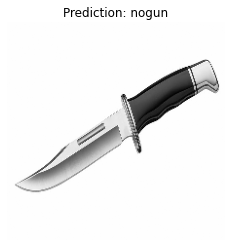

In [43]:
pred_and_plot(model, '/content/weapon_detection/val/images/nogun/Knife_53.jpeg',['gun','nogun'])

1/1 [==============================] - 0s 22ms/step


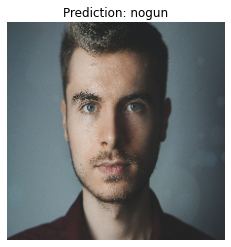

In [50]:
pred_and_plot(model, '/content/test/test/pexels-simon-robben-614810.jpg',['gun','nogun'])
